In [ ]:
from sklearn import datasets
iris = datasets.load_iris()

In [ ]:
X=iris['data']
Y=iris['target']

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
def data_to_image(data):
    desire_col = 2
    desire_row = data.shape[1]/desire_col
    data_images = []
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", size=35)
    for dat in data:
        background = np.zeros((255,255)).astype('uint8') #np.array([[0 for _ in range(255)] for _ in range(255)], dtype='uint8')
        image = Image.fromarray(background)
        draw = ImageDraw.Draw(image)
        for c, val in enumerate(dat):
            if len(str(val)) > 6: draw.text(((255//desire_col)*(c%desire_col), (255//desire_row)*(c//desire_col)), str(val)[:5], fill='white', font = font )
            else: draw.text(((255//desire_col)*(c%desire_col), (255//desire_row)*(c//desire_col)), str(val) , font = font, fill='white') 
        #rgb = np.array(image, dtype='uint8')
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        data_images.append(rgb)
    return np.array(data_images) / 255 

X=data_to_image(X)

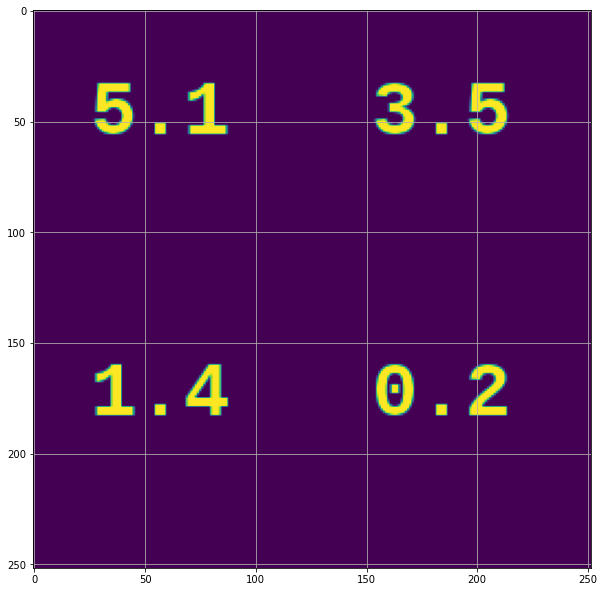

In [4]:
X=np.array([[np.pad(x[:200,:200],26) for x in k] for k in X])
plt.figure(figsize = (10,12))
plt.grid()
plt.imshow(X[0,0,...])  # each number is value from features, we have 5 columns and 23 rows => 115 features as it should be

### ResNet18

In [5]:
import torch.nn as nn
from torchvision import models


def resnet18update(net, only_last = True):
   if only_last:
      for name, param in net.named_parameters():
        if 'fc' not in name and 'act' not in name: param.requires_grad = False  # freezing all except classifier
      for name, param in net.layer4[1].named_parameters():
        param.requires_grad = True   # unfreezing last sub-block
   else:
      for name, param in net.named_parameters():
          if 'layer4' not in name:
              param.requires_grad = False
          else:
              break
   for name, param in net.named_parameters():
        if param.requires_grad: print(name)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import torchvision
from torchvision import *

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

## Train Validation

In [7]:
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test=tts(X,Y, test_size=0.2,random_state=8)

device=torch.device('cpu')
train_data = torch.utils.data.DataLoader(list(zip(x_train,y_train)), batch_size=8, shuffle=True, drop_last=True,num_workers=2)
validation_data = torch.utils.data.DataLoader(list(zip(x_test,y_test)),batch_size=1000,num_workers=2)

In [ ]:
def accuracy(pred,y):
    return sum(pred==y)/len(y)
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from sklearn.model_selection import KFold


Train_stats=[]
Test_stats=[]
for fold, (train_index, test_index)  in enumerate(KFold(n_splits=10,shuffle=True).split(X)):
 train_data = torch.utils.data.DataLoader(list(zip(X[train_index],Y[train_index])), batch_size=8, shuffle=True, drop_last=True,num_workers=2)
 validation_data = torch.utils.data.DataLoader(list(zip(X[test_index],Y[test_index])),batch_size=1,num_workers=2) 

 net = models.resnet18(pretrained=True)
 num_features = net.fc.in_features
 net.fc= nn.Linear(num_features, 3)            
 resnet18update(net)
 net = nn.Sequential(net, nn.Softmax(1)) 

 #loss and optim
 criterion = nn.CrossEntropyLoss()
 optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
 
 for epoch in range(10):
   
    Stats=[]
    Names=['Fold','Epoch','Accuracy','Loss','Precision','Recall','f1_score']

    for i, (inputs, labels) in enumerate(train_data):
        net.train()
        inputs = inputs.to(device, dtype=torch.float); 
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([fold+1,epoch+1,accuracy(pred,labels),loss.item(),precision_score(labels, pred,average=average),recall_score(labels, pred,average=average),f1_score(labels, pred,average=average)])
    Train_stats.append({key:val for key,val in zip(Names,np.asarray(Stats).T)})
    print("-----      TRAIN RESULTS      -----")
    print({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})
 
    Stats=[]

    for i, (inputs, labels) in enumerate(validation_data):
        net.eval()
        inputs = inputs.to(device, dtype=torch.float); 
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([fold+1,epoch+1,accuracy(pred,labels),loss.item(),precision_score(labels, pred,average=average),recall_score(labels, pred,average=average),f1_score(labels, pred,average=average)])
 
    Test_stats.append({key:val for key,val in zip(Names,np.asarray(Stats).T)})
    print("-----       TEST RESULTS     ---")
    print({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias
-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 1.0, 'Accuracy': 0.3828125, 'Loss': 1.0988524034619331, 'Precision': 0.3828125, 'Recall': 0.3828125, 'f1_score': 0.3828125}
-----       TEST RESULTS     ---
{'Fold': 1.0, 'Epoch': 1.0, 'Accuracy': 0.26666666666666666, 'Loss': 1.1238214015960692, 'Precision': 0.26666666666666666, 'Recall': 0.26666666666666666, 'f1_score': 0.26666666666666666}
-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 2.0, 'Accuracy': 0.7109375, 'Loss': 0.9887997284531593, 'Precision': 0.7109375, 'Recall': 0.7109375, 'f1_score': 0.7109375}
-----       TEST RESULTS     ---
{'Fold': 1.0, 'Epoch': 2.0, 'Accuracy': 0.4666666666666667, 'Loss': 1.0954986731211345, 'Precision': 0.4666666666666667, 'Recall': 0.4666666666666667, 'f1_score': 0.4666666666666667}
-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 3

In [ ]:
Data=pd.DataFrame(Test_stats[0]).iloc[1:]
for S in Test_stats:
 Data=Data.append(pd.DataFrame(S))

In [ ]:
Data.groupby('Epoch').sum(['Loss','Precision','Recall','f1_score'])